# 1. 라이브러리 임포트 및 설정

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
import os

# ==========================================
# [Configuration] 하이퍼파라미터 설정
# ==========================================
config = {
    'file_path': 'chirp_dataset.mat',
    'batch_size': 128,
    'lr': 0.001,
    'epochs': 100,
    'patience': 10,
    'seed': 42,
    'val_ratio': 0.2,
    'test_ratio': 0.2,
    'fs': 100e6  # 100MHz
}

# GPU 설정 및 시드 고정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(config['seed'])
np.random.seed(config['seed'])

# PSNR 계산 함수 정의
def calculate_psnr_tensor(pred, target):
    mse = torch.mean((pred - target) ** 2)
    if mse == 0:
        return torch.tensor(100.0)
    return 20 * torch.log10(1.0 / torch.sqrt(mse))

print(f"✅ 실행 준비 완료 (장치: {device})")

✅ 실행 준비 완료 (장치: cuda)


# 2. 데이터 로드 및 전처리

In [16]:
try:
    with h5py.File(config['file_path'], 'r') as f:
        print(f"📦 변수 목록: {list(f.keys())}")
        
        X_raw = np.array(f['X_noisy']).T
        Y_raw = np.array(f['Y_clean']).T
        SNR_log = np.array(f['SNR_log']).T
        
        def to_complex(data):
            if data.dtype.names is not None and 'real' in data.dtype.names:
                return data['real'] + 1j * data['imag']
            return data

        X_noisy_all = to_complex(X_raw)
        Y_clean_all = to_complex(Y_raw)

    print(f"✅ 데이터 로드 및 변환 성공! Shape: {X_noisy_all.shape}")

except Exception as e:
    print(f"❌ 에러 발생: {e}")

📦 변수 목록: ['SNR_log', 'X_noisy', 'Y_clean']
✅ 데이터 로드 및 변환 성공! Shape: (5000, 1024)


# 3. 데이터셋 및 DataLoader 구성

In [17]:
class RadarDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = x_data
        self.y_data = y_data

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        # Real/Imag 2채널 분할 [2, 1024]
        x_2ch = np.stack([np.real(self.x_data[idx]), np.imag(self.x_data[idx])], axis=0)
        y_2ch = np.stack([np.real(self.y_data[idx]), np.imag(self.y_data[idx])], axis=0)
        return torch.from_numpy(x_2ch).float(), torch.from_numpy(y_2ch).float()

# 데이터셋 객체 생성 및 분할
full_dataset = RadarDataset(X_noisy_all, Y_clean_all)
total_len = len(full_dataset)
val_len = int(total_len * config['val_ratio'])
test_len = int(total_len * config['test_ratio'])
train_len = total_len - val_len - test_len

train_ds, val_ds, test_ds = random_split(
    full_dataset, [train_len, val_len, test_len],
    generator=torch.Generator().manual_seed(config['seed'])
)

# 로더 생성
train_loader = DataLoader(train_ds, batch_size=config['batch_size'], shuffle=True)
val_loader = DataLoader(val_ds, batch_size=config['batch_size'], shuffle=False)
test_loader = DataLoader(test_ds, batch_size=config['batch_size'], shuffle=False)

print(f"📊 분할 결과 - Train: {train_len}, Val: {val_len}, Test: {test_len}")

📊 분할 결과 - Train: 3000, Val: 1000, Test: 1000


# 4. 모델 정의 및 학습 준비

In [18]:
class RadarDenoiseNet(nn.Module):
    def __init__(self):
        super(RadarDenoiseNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(2, 64, kernel_size=9, padding=4),
            nn.BatchNorm1d(64), nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm1d(128), nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Conv1d(128, 64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64), nn.ReLU(),
            nn.Conv1d(64, 2, kernel_size=3, padding=1)
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

model = RadarDenoiseNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=config['lr'])

# 히스토리 저장을 위한 리스트
train_loss_history, val_loss_history = [], []
train_psnr_history, val_psnr_history = [], []
best_val_loss = float('inf')

# 5. 학습 진행 (Training Loop)

In [19]:
print("🚀 학습 시작...")

early_stop_counter = 0  # 개선되지 않은 에폭 횟수를 세는 카운터
best_val_loss = float('inf')

for epoch in range(config['epochs']):
    model.train()
    running_train_loss, running_train_psnr = 0.0, 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item()
        running_train_psnr += calculate_psnr_tensor(outputs, labels).item()
    
    model.eval()
    running_val_loss, running_val_psnr = 0.0, 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            running_val_loss += criterion(outputs, labels).item()
            running_val_psnr += calculate_psnr_tensor(outputs, labels).item()
            
    avg_train_loss = running_train_loss / len(train_loader)
    avg_val_loss = running_val_loss / len(val_loader)
    avg_train_psnr = running_train_psnr / len(train_loader)
    avg_val_psnr = running_val_psnr / len(val_loader)
    
    train_loss_history.append(avg_train_loss)
    val_loss_history.append(avg_val_loss)
    train_psnr_history.append(avg_train_psnr)
    val_psnr_history.append(avg_val_psnr)

    # --- 얼리 스토핑 및 모델 저장 로직 ---
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_denoise_model.pth')
        early_stop_counter = 0  # 성능이 개선되었으므로 카운터 초기화
        print(f"✨ Epoch [{epoch+1}] - Best Model Saved! (Val Loss: {avg_val_loss:.6f})")
    else:
        early_stop_counter += 1 # 성능 개선 없음
        if early_stop_counter >= config['patience']:
            print(f"🛑 Early Stopping! {config['patience']}번의 에폭 동안 개선이 없어 학습을 종료합니다.")
            break # 학습 루프 탈출
    
    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{config['epochs']}] Loss: {avg_train_loss:.6f}/{avg_val_loss:.6f} | PSNR: {avg_train_psnr:.2f}dB/{avg_val_psnr:.2f}dB")

print("✨ 학습 완료!")

🚀 학습 시작...
✨ Epoch [1] - Best Model Saved! (Val Loss: 0.026639)
✨ Epoch [2] - Best Model Saved! (Val Loss: 0.005233)
✨ Epoch [3] - Best Model Saved! (Val Loss: 0.004174)
✨ Epoch [4] - Best Model Saved! (Val Loss: 0.003536)
✨ Epoch [5] - Best Model Saved! (Val Loss: 0.003343)
Epoch [5/100] Loss: 0.003437/0.003343 | PSNR: 24.65dB/24.76dB
✨ Epoch [6] - Best Model Saved! (Val Loss: 0.003242)
✨ Epoch [7] - Best Model Saved! (Val Loss: 0.003084)
✨ Epoch [8] - Best Model Saved! (Val Loss: 0.003073)
✨ Epoch [9] - Best Model Saved! (Val Loss: 0.002894)
Epoch [10/100] Loss: 0.002906/0.002931 | PSNR: 25.38dB/25.33dB
✨ Epoch [11] - Best Model Saved! (Val Loss: 0.002760)
✨ Epoch [15] - Best Model Saved! (Val Loss: 0.002701)
Epoch [15/100] Loss: 0.002730/0.002701 | PSNR: 25.65dB/25.69dB
✨ Epoch [17] - Best Model Saved! (Val Loss: 0.002526)
✨ Epoch [20] - Best Model Saved! (Val Loss: 0.002473)
Epoch [20/100] Loss: 0.002594/0.002473 | PSNR: 25.88dB/26.07dB
✨ Epoch [22] - Best Model Saved! (Val Loss: 0

# 6. 학습 결과 곡선 시각화

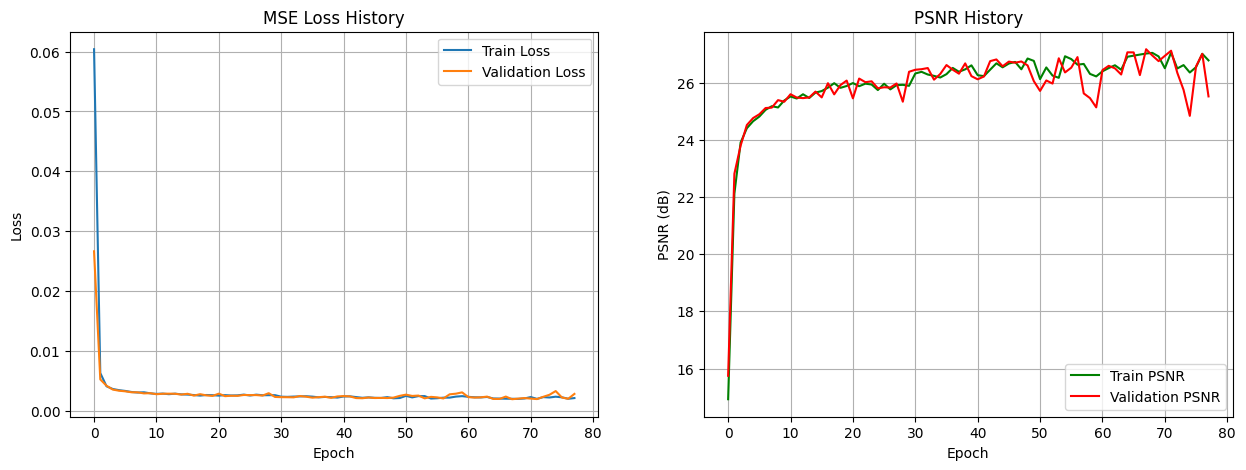

In [20]:
plt.figure(figsize=(15, 5))

# Loss 곡선
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.title("MSE Loss History")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.grid(True)

# PSNR 곡선
plt.subplot(1, 2, 2)
plt.plot(train_psnr_history, label='Train PSNR', color='green')
plt.plot(val_psnr_history, label='Validation PSNR', color='red')
plt.title("PSNR History")
plt.xlabel("Epoch"); plt.ylabel("PSNR (dB)"); plt.legend(); plt.grid(True)

plt.show()

# 7. 최종 테스트 및 결과물 비교

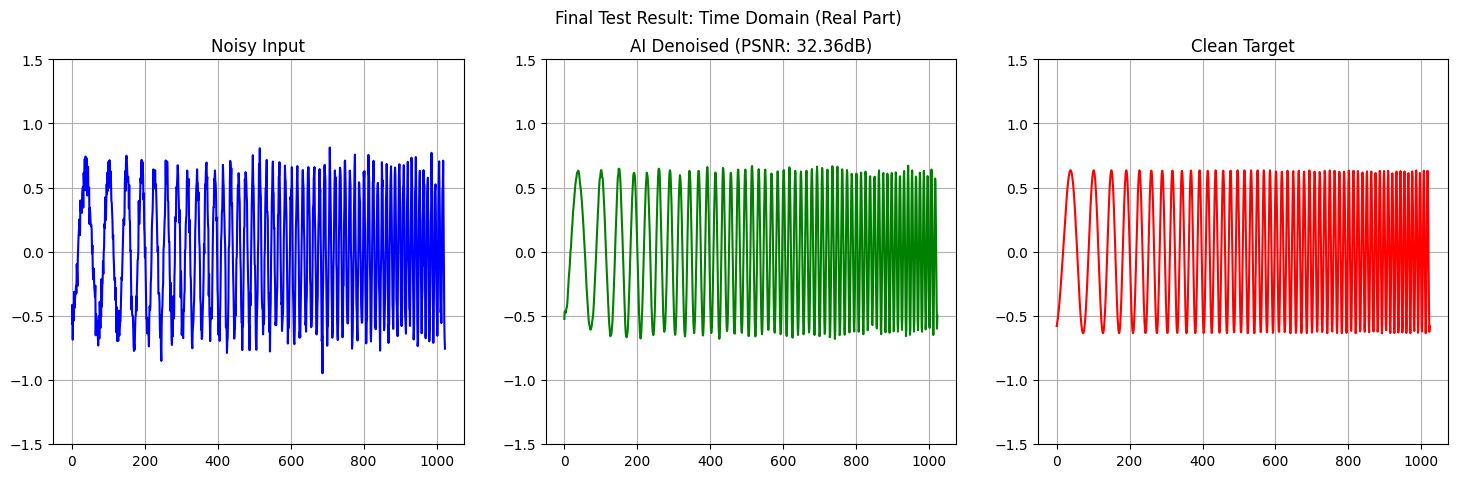

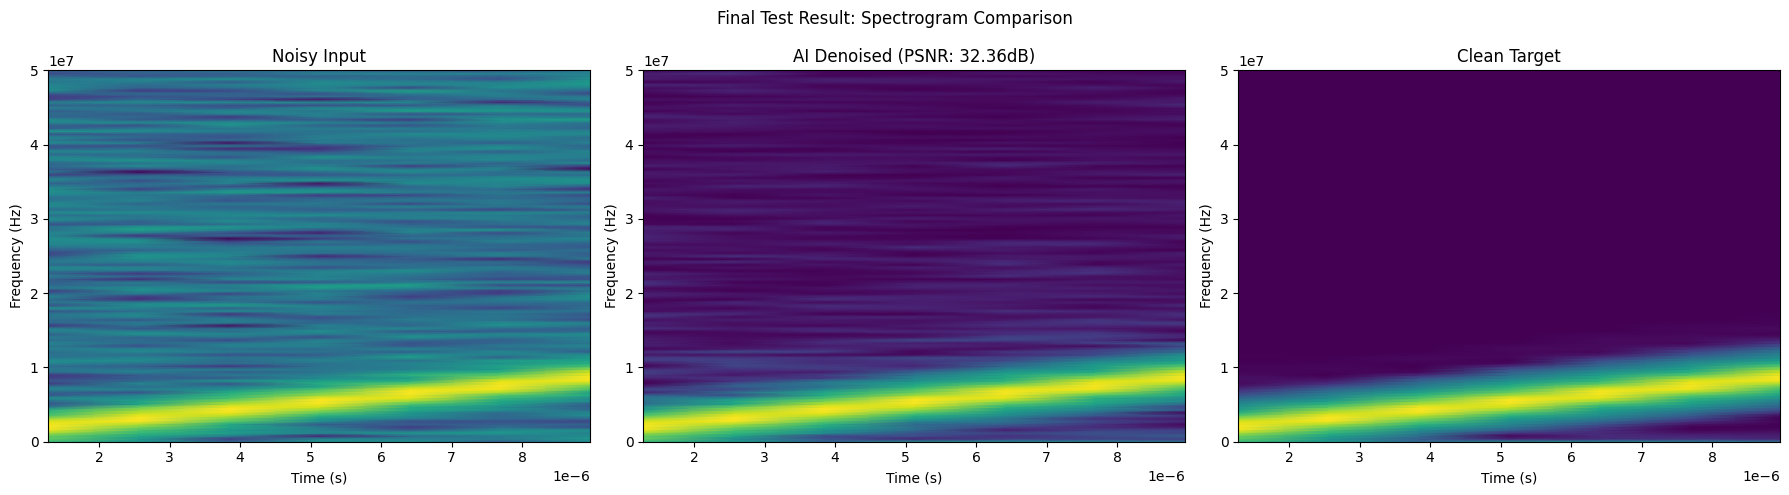

In [21]:
# 스펙트로그램 함수 정의
def plot_spectrogram(x, fs, title):
    f, t, Sxx = spectrogram(x, fs=fs, nperseg=256, noverlap=128)
    plt.pcolormesh(t, f, 10*np.log10(Sxx + 1e-12), shading='gouraud')
    plt.ylabel('Frequency (Hz)'); plt.xlabel('Time (s)'); plt.title(title)

# 베스트 모델 로드 (weights_only=True 추가)
model.load_state_dict(torch.load('best_denoise_model.pth', weights_only=True))
model.eval()

with torch.no_grad():
    test_in, test_target = next(iter(test_loader)) 
    test_in = test_in.to(device)
    prediction = model(test_in)
    
    idx = 0 # 확인할 샘플 인덱스
    in_np = test_in[idx].cpu().numpy()
    target_np = test_target[idx].cpu().numpy()
    pred_np = prediction[idx].cpu().numpy()
    sample_psnr = calculate_psnr_tensor(prediction[idx], test_target[idx].to(device)).item()

        # --- 파형 비교 부분 수정 ---
    plt.figure(figsize=(18, 5))

    # 순서를 [Noisy, Denoised, Clean]으로 변경
    titles = ["Noisy Input", f"AI Denoised (PSNR: {sample_psnr:.2f}dB)", "Clean Target"]
    datas = [in_np[0, :], pred_np[0, :], target_np[0, :]]
    colors = ['b', 'g', 'r'] # 파랑(노이즈), 초록(결과), 빨강(정답)

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.plot(datas[i], colors[i])
        plt.title(titles[i])
        plt.ylim(-1.5, 1.5)
        plt.grid(True)
    plt.suptitle("Final Test Result: Time Domain (Real Part)")
    plt.show()

    # --- 스펙트로그램 비교 부분 수정 ---
    plt.figure(figsize=(18, 5))
    for i in range(3):
        plt.subplot(1, 3, i+1)
        # 위에서 정의한 datas와 titles의 바뀐 순서를 그대로 사용합니다.
        plot_spectrogram(datas[i], config['fs'], titles[i])
    plt.suptitle("Final Test Result: Spectrogram Comparison")
    plt.tight_layout()
    plt.show()